In [1]:
from sksurv.datasets import load_gbsg2
import numpy as np
import pandas as pd
from survONS import surv_ons, survive, hazard
import matplotlib.pyplot as plt

x, y = load_gbsg2()
df = pd.DataFrame(y)
df.head(10)

def cancer_levels(val):
    if val == "I":
        return 1
    elif val == "II":
        return 2
    elif val == "III":
        return 3
    else:
        return 0
x["horTh"] = x["horTh"].cat.codes
x["menostat"] = x["menostat"].apply(lambda val: 0 if (val == "Pre") else 1)
x["tgrade"] = x["tgrade"].apply(lambda val: cancer_levels(val))
#x.head()

In [2]:
N = x.shape[0]  #Número de individuosid
n_it = int(max(y["time"]))
max_t = df["time"].max()
d = x.shape[1]

eta = np.zeros((3,1))
sigma = np.eye(3,3)

gamma = np.arange(np.log(1/n_it), np.log(50), 1.2)
gamma = np.exp(gamma)

K = len(gamma)
M = 5

beta_real = np.zeros((d, M))
grid_bound = np.zeros((M, 1))

beta_surv = np.zeros((n_it,d,M))

like_surv = np.zeros((n_it, M))

gamma_t = np.zeros((n_it, M))

X = x.to_numpy()
t0 = np.zeros(N)
u = y["time"]
delta = y["cens"]
D = 2.5
n = n_it
epsilon = 1/(gamma*D) ** 2
R = [[] for _ in range(n_it)]

for t in range(0, n_it):
    R[t].append(0)
for i in range(1, N):
    t1 = max(1,int(np.floor(0)-1)) # tiempo en el que i entra al estudio
    t2 = min(n_it,int(np.floor(u[i])+1)) # tiempo en el que i sale del estudio
    for t in range(t1, t2):
        R[t].append(i)
        
survons = surv_ons(t0, u, delta, X, D, gamma, n, epsilon, R)
beta_surv[:,:,0] = survons["beta_boa_arr"]
print(beta_surv[:,:,0])
G = max([np.sqrt(np.matmul(survons["grad_boa"][j].T, survons["grad_boa"][j])) for j in range(n_it)])
print(G)
grid_bound[0] = 1/(4*G*D)
print(grid_bound[0])
gamma_t[:,0] = survons["gamma_temp"].flatten()
like_surv[:, 0] = survons["lik_boa"].flatten()

beta_surv_mean = np.mean(beta_surv, axis = 0)
print(beta_surv_mean)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.52841165e-04 -1.18443835e-03 -4.41278581e-06 ... -1.35355927e-03
  -2.60461992e-05 -3.60915653e-04]
 [-1.96332591e-02 -1.52228403e-03 -2.29346653e-04 ...  6.19622021e-03
  -1.43559727e-03 -1.50292833e-02]
 ...
 [-1.07863793e-01 -1.99087495e-02 -2.75961645e-01 ... -1.99614280e-03
  -2.58562974e-01 -2.51956556e-03]
 [-1.07864775e-01 -1.99089005e-02 -2.75966640e-01 ... -1.99619097e-03
  -2.58570785e-01 -2.51954883e-03]
 [-1.07865757e-01 -1.99090515e-02 -2.75971634e-01 ... -1.99623914e-03
  -2.58578596e-01 -2.51953211e-03]]
411489.5659540404
[2.43019528e-07]
[[-0.11554078  0.          0.          0.          0.        ]
 [-0.02687661  0.          0.          0.          0.        ]
 [-0.17838806  0.          0.          0.          0.        ]
 [ 0.13820767  0.          0.          0.          0.        ]
 [-0.02033161  0.          0.          0.          0.        ]
 [-0.00213182 

Text(0, 0.5, 'Probabilidad de supervivencia')

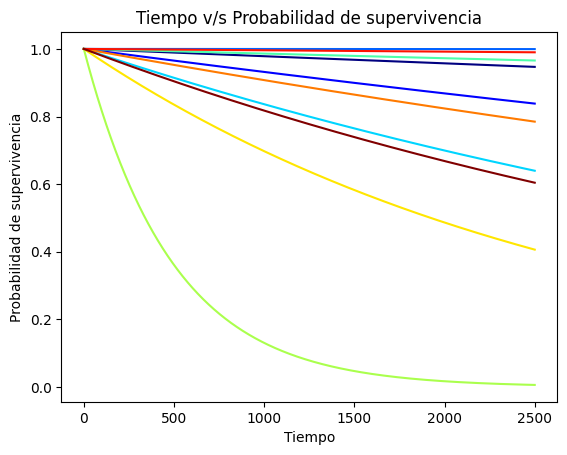

In [3]:
survival = [[survive(X[i], beta_surv_mean, t, 0) for t in range(2500)] for i in range(10)]

colors = plt.cm.jet(np.linspace(0, 1, len(survival)))
for indv in survival:
    plt.plot([i for i in range(2500)], indv, label=f"Individuo {survival.index(indv) + 1}", color=colors[survival.index(indv)])
plt.title("Tiempo v/s Probabilidad de supervivencia")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de supervivencia")
#plt.legend()

In [4]:
# # Simulación sin dataset
# N2 = 1000
# n_it2 = 1000
# max_T = 1000
# d2 = 4
# eta2 = np.zeros((3,))
# sigma2 = np.eye(3,3)
# gamma2 = np.arange(np.log(1/n_it2), np.log(50), 1.2)
# gamma2 = np.exp(gamma2)
# K2 = len(gamma2)

# M2 = 1
# beta_real2 = np.zeros((d2, M2))
# grid_bound2 = np.zeros((M2, 1))
# beta_surv2 = np.zeros((n_it2,d2,M2))
# like_surv2 = np.zeros((n_it2, M2))
# gamma_t2 = np.zeros((n_it2, M2))

# for i in range(M2):
#     beta_real2[: , i] = np.random.normal(loc=0, scale=1, size=d2)
#     D2 = 1.1 * np.sqrt(np.dot(beta_real2[:, i].T, beta_real2[:, i]))
#     epsilon = 1/(gamma2*D2) ** 2
        
#     X2 = np.random.multivariate_normal(eta2, sigma2, N2)
#     X2_1 = np.column_stack((np.ones(N2), X2))
        
#     arrival_time = np.array([0 for i in range(0, N2)]) #np.random.uniform(0, max_T, N2)
#     random_time = lambda x: x + (max_T - x) * np.random.rand()
#     time_indiv = np.array([random_time(xi) for xi in arrival_time])
#     censor_indiv = np.array([random_time(xi) for xi in arrival_time])
#     # time_indiv  = arrival_time + np.array([np.random.exponential(
#     #     1 / np.exp(np.dot(beta_real2[:, i].T, X2_1[j, ])))
#     #      for j in range(N2)])
#     # censor_indiv = arrival_time + np.array([np.random.exponential(
#     #     1 / np.exp(np.dot(beta_real2[:, i].T, X2_1[j, ])))
#     #      for j in range(N2)])
#     u2 = np.array([min(time_indiv[i], censor_indiv[i]) for i in range(N2)])
#     delta = time_indiv < censor_indiv
        
#     R2 = [[] for _ in range(n_it2)]

#     for t in range(0, n_it2):
#         R2[t].append(0)
#     for j in range(1, N2):
#         t1 = max(1,int(np.floor(arrival_time[j])-1)) # tiempo en el que i entra al estudio
#         t2 = min(n_it2,int(np.floor(u2[j])+1)) # tiempo en el que i sale del estudio
#         for t in range(t1, t2):
#             R2[t].append(j)

#     surv = surv_ons(arrival_time, u2, delta, X2_1, D2, gamma2, n_it2, epsilon, R2)
#     #print(surv)
#     beta_surv2[:,:,i] = surv["beta_boa_arr"]
#     print(beta_surv2[:,:,i])
#     G2 = max([np.sqrt(np.matmul(surv["grad_boa"][j].T, surv["grad_boa"][j])) for j in range(n_it2)])
#     print(G2)
#     grid_bound2[i] = 1/(4*G2*D2)
#     print(grid_bound2[i])
#     gamma_t2[:,i] = surv["gamma_temp"].flatten()
#     like_surv2[:, i] = surv["lik_boa"].flatten()


In [5]:
# beta_surv_mean = np.mean(beta_surv2, axis = 0)
# print(beta_surv_mean)

# survival = [survive(X2_1[500], beta_surv_mean, t, 0) for t in range(20)]

# import matplotlib.pyplot as plt

# plt.plot([i for i in range(20)], survival)
# plt.title("Tiempo v/s Probabilidad de supervivencia")
# plt.xlabel("Tiempo")
# plt.ylabel("Probabilidad de supervivencia")
